In [1]:
# load data
import pandas as pd
import numpy as np
from pandas import DataFrame
base_path='D:/kaggle/regression/'
all_data=DataFrame.from_csv(base_path+'cleaned_train.csv',index_col='Id')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 263 entries, LotFrontage to SaleCondition__Partial
dtypes: float64(231), int64(32)
memory usage: 2.9 MB


In [11]:
# This visualization serves while tuning parameters one by one
# Reference https://www.zhihu.com/question/34470160

In [2]:
all_id=all_data.index
all_y=all_data['SalePrice']
all_x=all_data.drop(['SalePrice'],axis=1)
all_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 262 entries, LotFrontage to SaleCondition__Partial
dtypes: float64(231), int64(31)
memory usage: 2.9 MB


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(all_x, all_y, test_size=0.2, random_state=42)

In [4]:
def reportParams(best_parameters, score):
    print('score:', score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))

In [5]:
from sklearn.metrics import mean_squared_error

def rmse_log_error(predict,reality):
    predict_log=np.log(predict)
    reality_log=np.log(reality)
    mse=mean_squared_error(reality_log, predict_log)
    rmse=np.sqrt(mse)
    return rmse

In [6]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# This makes jupyter show matplotlib graphs in the page

In [7]:
from sklearn.metrics import make_scorer

# Write my own scoring function for the GridSearchCV
def rmse_log_loss_func(ground_truth, predictions):
    return rmse_log_error(predictions,ground_truth)

rmse_loss  = make_scorer(rmse_log_loss_func, greater_is_better=False)

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Tune the number of estimators
print "Random forest with mse"
params={
    'n_estimators':[x for x in range(10,300,10)]
        }
from sklearn.grid_search import GridSearchCV
rfc = RandomForestRegressor(criterion='mse', n_jobs=-1,random_state=42)
gs = GridSearchCV(rfc, params,cv=5,scoring=rmse_loss,verbose=3)
gs.fit(X_train, y_train)
print 'Report scores'
print gs.grid_scores_
print("Report best params for random forest")
best_parameters, score, _ = max(gs.grid_scores_, key=lambda x: x[1])
reportParams(best_parameters, score)


# get the best regressor
rfc_best=gs.best_estimator_
print 'Params for best estimator are ',rfc_best.get_params()
rfc_best.fit(X_train,y_train)
print 'Now predict'
rfc_predict=rfc_best.predict(X_train)
print 'Predicted values are ',rfc_predict
print('RFC MSE {score}'.format(score=rmse_log_error(y_train, rfc_predict)))

# Calculate stats
predict_series=pd.Series(rfc_predict)
print "Std: ",np.std(predict_series)," Mean: ",np.mean(predict_series)
print 'Min: ',min(predict_series),' Max: ',max(predict_series)

Random forest with mse
Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] n_estimators=10 .................................................
[CV] ....................... n_estimators=10, score=-0.143137 -   0.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ....................... n_estimators=10, score=-0.168384 -   0.3s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ....................... n_estimators=10, score=-0.176475 -   0.3s
[CV] n_estimators=10 .................................................
[CV] ....................... n_estimators=10, score=-0.147857 -   0.3s
[CV] n_estimators=10 .................................................
[CV] ....................... n_estimators=10, score=-0.130239 -   0.3s
[CV] n_estimators=20 .................................................
[CV] ....................... n_estimators=20, score=-0.137146 -   0.3s
[CV] n_estimators=20 .................................................
[CV] ....................... n_estimators=20, score=-0.162784 -   0.3s
[CV] n_estimators=20 .................................................
[CV] ....................... n_estimators=20, score=-0.180578 -   0.3s
[CV] n_estimators=20 .................................................
[CV] ....................... n_estimators=20, score=-0.141805 -   0.2s
[CV] n_estimators=20 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  3.3min finished


Report scores
[mean: -0.15324, std: 0.01691, params: {'n_estimators': 10}, mean: -0.14984, std: 0.01935, params: {'n_estimators': 20}, mean: -0.14921, std: 0.01865, params: {'n_estimators': 30}, mean: -0.14886, std: 0.01943, params: {'n_estimators': 40}, mean: -0.14856, std: 0.01969, params: {'n_estimators': 50}, mean: -0.14822, std: 0.01944, params: {'n_estimators': 60}, mean: -0.14737, std: 0.01937, params: {'n_estimators': 70}, mean: -0.14711, std: 0.01947, params: {'n_estimators': 80}, mean: -0.14701, std: 0.01949, params: {'n_estimators': 90}, mean: -0.14691, std: 0.01957, params: {'n_estimators': 100}, mean: -0.14669, std: 0.01938, params: {'n_estimators': 110}, mean: -0.14659, std: 0.01945, params: {'n_estimators': 120}, mean: -0.14653, std: 0.01967, params: {'n_estimators': 130}, mean: -0.14653, std: 0.01961, params: {'n_estimators': 140}, mean: -0.14623, std: 0.01946, params: {'n_estimators': 150}, mean: -0.14631, std: 0.01943, params: {'n_estimators': 160}, mean: -0.14623, st

In [16]:
# This function visualizes the mean/std of tuning results. 
# This only works when you tune one parameter
def draw_result(scores,param_name):
    print scores
    
    # process scores
    means=[]
    stds=[]
    x_values=[]
    for t in scores:
        # Plot the absolute value of the score
        means.append(abs(t.mean_validation_score))
        stds.append(np.std(t.cv_validation_scores))
        params=t.parameters
        x_values.append(params[param_name])
    print 'Scores converted to ',
    print means
    print stds
    print x_values
    
    # plot
    f1 = plt.figure(figsize=(12, 6))
    f2 = plt.figure(figsize=(12, 6))
    ax1 = f1.add_subplot(111)
    ax1.plot(x_values,means)
    ax3 = f1.add_subplot(111)
    for xy in zip(x_values, means):                                       
        ax3.annotate('%s' % str(round(xy[1],4)), xy=xy, textcoords='data')
    
    ax2 = f2.add_subplot(111)
    ax2.plot(x_values,stds)
    ax4 = f2.add_subplot(111)
    for xy in zip(x_values, stds):                                       
        ax4.annotate('%s' % str(round(xy[1],4)), xy=xy, textcoords='data')
    
    # show what has been plotted
    plt.show()

[mean: -0.15324, std: 0.01691, params: {'n_estimators': 10}, mean: -0.14984, std: 0.01935, params: {'n_estimators': 20}, mean: -0.14921, std: 0.01865, params: {'n_estimators': 30}, mean: -0.14886, std: 0.01943, params: {'n_estimators': 40}, mean: -0.14856, std: 0.01969, params: {'n_estimators': 50}, mean: -0.14822, std: 0.01944, params: {'n_estimators': 60}, mean: -0.14737, std: 0.01937, params: {'n_estimators': 70}, mean: -0.14711, std: 0.01947, params: {'n_estimators': 80}, mean: -0.14701, std: 0.01949, params: {'n_estimators': 90}, mean: -0.14691, std: 0.01957, params: {'n_estimators': 100}, mean: -0.14669, std: 0.01938, params: {'n_estimators': 110}, mean: -0.14659, std: 0.01945, params: {'n_estimators': 120}, mean: -0.14653, std: 0.01967, params: {'n_estimators': 130}, mean: -0.14653, std: 0.01961, params: {'n_estimators': 140}, mean: -0.14623, std: 0.01946, params: {'n_estimators': 150}, mean: -0.14631, std: 0.01943, params: {'n_estimators': 160}, mean: -0.14623, std: 0.01947, pa

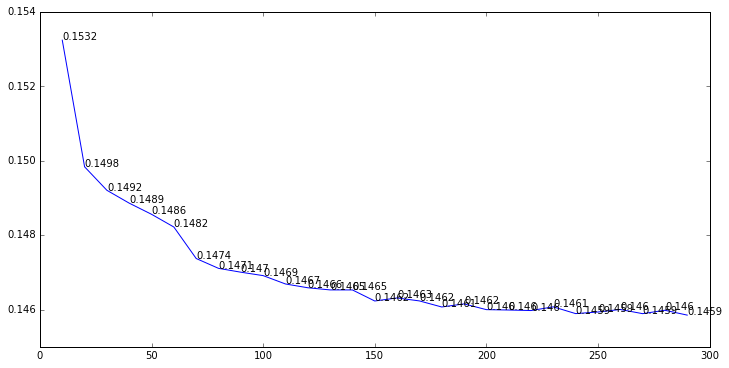

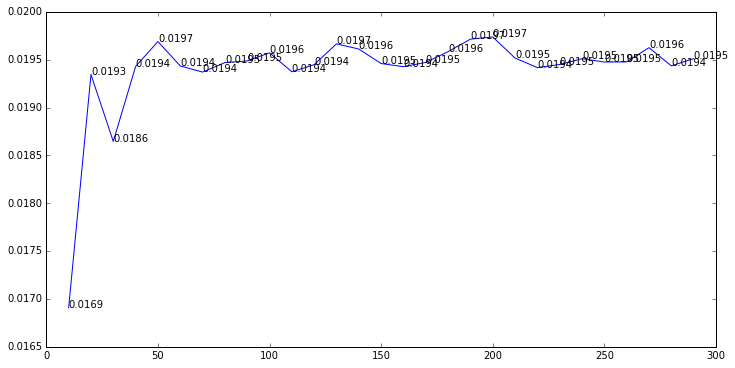

In [19]:
# Visualize the tuning effectiveness of tuning
draw_result(gs.grid_scores_,'n_estimators')

# ~250 seems reasonable

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

# Tune the max feature num
print "Random forest with mse"
params={
    'n_estimators':[250],
    'max_features':np.linspace(0.001, 1.0, num=20, endpoint=True)
        }
print 'Params to search ',
print params

rfc = RandomForestRegressor(criterion='mse', n_jobs=-1,random_state=42)
gs = GridSearchCV(rfc, params,cv=5,scoring=rmse_loss,verbose=3)
gs.fit(X_train, y_train)
print 'Report scores'
print gs.grid_scores_
print("Report best params for random forest")
best_parameters, score, _ = max(gs.grid_scores_, key=lambda x: x[1])
reportParams(best_parameters, score)


# get the best regressor
rfc_best=gs.best_estimator_
print 'Params for best estimator are ',rfc_best.get_params()
rfc_best.fit(X_train,y_train)
print 'Now predict'
rfc_predict=rfc_best.predict(X_train)
print 'Predicted values are ',rfc_predict
print('RFC MSE {score}'.format(score=rmse_log_error(y_train, rfc_predict)))

# Calculate stats
predict_series=pd.Series(rfc_predict)
print "Std: ",np.std(predict_series)," Mean: ",np.mean(predict_series)
print 'Min: ',min(predict_series),' Max: ',max(predict_series)

Random forest with mse
Params to search  {'n_estimators': [250], 'max_features': array([ 0.001     ,  0.05357895,  0.10615789,  0.15873684,  0.21131579,
        0.26389474,  0.31647368,  0.36905263,  0.42163158,  0.47421053,
        0.52678947,  0.57936842,  0.63194737,  0.68452632,  0.73710526,
        0.78968421,  0.84226316,  0.89484211,  0.94742105,  1.        ])}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_features=0.001, n_estimators=250 ............................
[CV] .. max_features=0.001, n_estimators=250, score=-0.174673 -   1.0s
[CV] max_features=0.001, n_estimators=250 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .. max_features=0.001, n_estimators=250, score=-0.170840 -   1.0s
[CV] max_features=0.001, n_estimators=250 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] .. max_features=0.001, n_estimators=250, score=-0.225438 -   1.1s
[CV] max_features=0.001, n_estimators=250 ............................
[CV] .. max_features=0.001, n_estimators=250, score=-0.176399 -   0.9s
[CV] max_features=0.001, n_estimators=250 ............................
[CV] .. max_features=0.001, n_estimators=250, score=-0.156702 -   1.0s
[CV] max_features=0.0535789473684, n_estimators=250 ..................
[CV]  max_features=0.0535789473684, n_estimators=250, score=-0.138037 -   1.0s
[CV] max_features=0.0535789473684, n_estimators=250 ..................
[CV]  max_features=0.0535789473684, n_estimators=250, score=-0.153869 -   1.1s
[CV] max_features=0.0535789473684, n_estimators=250 ..................
[CV]  max_features=0.0535789473684, n_estimators=250, score=-0.181969 -   1.0s
[CV] max_features=0.0535789473684, n_estimators=250 ..................
[CV]  max_features=0.0535789473684, n_estimators=250, score=-0.139904 -   1.1s
[CV] max_features=0.0535789473684, n_estimato

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.7min finished


Report scores
[mean: -0.18083, std: 0.02336, params: {'max_features': 0.001, 'n_estimators': 250}, mean: -0.14666, std: 0.02080, params: {'max_features': 0.053578947368421052, 'n_estimators': 250}, mean: -0.14313, std: 0.02104, params: {'max_features': 0.1061578947368421, 'n_estimators': 250}, mean: -0.14198, std: 0.02082, params: {'max_features': 0.15873684210526315, 'n_estimators': 250}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21131578947368421, 'n_estimators': 250}, mean: -0.14128, std: 0.02097, params: {'max_features': 0.26389473684210524, 'n_estimators': 250}, mean: -0.14213, std: 0.01991, params: {'max_features': 0.3164736842105263, 'n_estimators': 250}, mean: -0.14141, std: 0.02017, params: {'max_features': 0.36905263157894735, 'n_estimators': 250}, mean: -0.14279, std: 0.02080, params: {'max_features': 0.42163157894736841, 'n_estimators': 250}, mean: -0.14263, std: 0.02116, params: {'max_features': 0.47421052631578947, 'n_estimators': 250}, mean: -0.14283, std:

[mean: -0.18083, std: 0.02336, params: {'max_features': 0.001, 'n_estimators': 250}, mean: -0.14666, std: 0.02080, params: {'max_features': 0.053578947368421052, 'n_estimators': 250}, mean: -0.14313, std: 0.02104, params: {'max_features': 0.1061578947368421, 'n_estimators': 250}, mean: -0.14198, std: 0.02082, params: {'max_features': 0.15873684210526315, 'n_estimators': 250}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21131578947368421, 'n_estimators': 250}, mean: -0.14128, std: 0.02097, params: {'max_features': 0.26389473684210524, 'n_estimators': 250}, mean: -0.14213, std: 0.01991, params: {'max_features': 0.3164736842105263, 'n_estimators': 250}, mean: -0.14141, std: 0.02017, params: {'max_features': 0.36905263157894735, 'n_estimators': 250}, mean: -0.14279, std: 0.02080, params: {'max_features': 0.42163157894736841, 'n_estimators': 250}, mean: -0.14263, std: 0.02116, params: {'max_features': 0.47421052631578947, 'n_estimators': 250}, mean: -0.14283, std: 0.02056, para

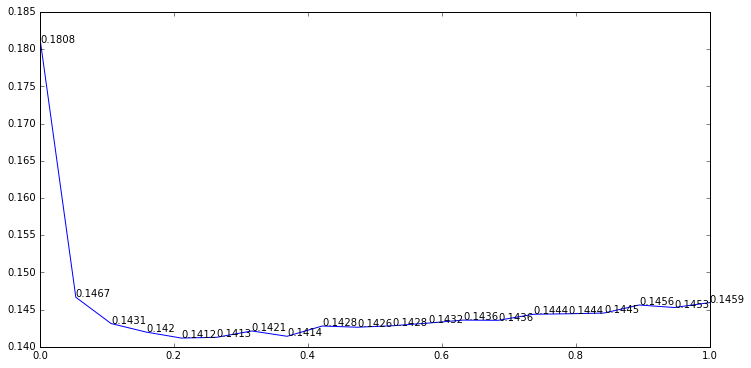

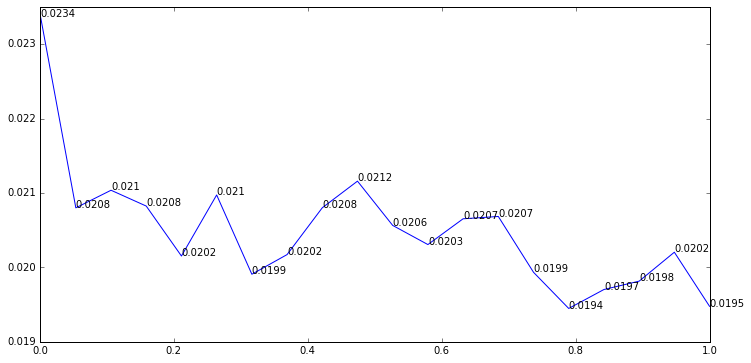

In [25]:
draw_result(gs.grid_scores_,'max_features')
# From the illustration the ideal range should be around 0.21

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

# Tune the max depth
print "Random forest with mse"
params={
    'n_estimators':[250],
    'max_features':[0.21],
    'max_depth':[x for x in range(1,100,5)]
        }
print 'Params to search ',
print params

rfc = RandomForestRegressor(criterion='mse', n_jobs=-1,random_state=42)
gs = GridSearchCV(rfc, params,cv=5,scoring=rmse_loss,verbose=3)
gs.fit(X_train, y_train)
print 'Report scores'
print gs.grid_scores_
print("Report best params for random forest")
best_parameters, score, _ = max(gs.grid_scores_, key=lambda x: x[1])
reportParams(best_parameters, score)


# get the best regressor
rfc_best=gs.best_estimator_
print 'Params for best estimator are ',rfc_best.get_params()
rfc_best.fit(X_train,y_train)
print 'Now predict'
rfc_predict=rfc_best.predict(X_train)
print 'Predicted values are ',rfc_predict
print('RFC MSE {score}'.format(score=rmse_log_error(y_train, rfc_predict)))

# Calculate stats
predict_series=pd.Series(rfc_predict)
print "Std: ",np.std(predict_series)," Mean: ",np.mean(predict_series)
print 'Min: ',min(predict_series),' Max: ',max(predict_series)

Random forest with mse
Params to search  {'n_estimators': [250], 'max_features': [0.21], 'max_depth': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_features=0.21, n_estimators=250, max_depth=1 ................
[CV]  max_features=0.21, n_estimators=250, max_depth=1, score=-0.270295 -   1.2s
[CV] max_features=0.21, n_estimators=250, max_depth=1 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  max_features=0.21, n_estimators=250, max_depth=1, score=-0.269953 -   1.3s
[CV] max_features=0.21, n_estimators=250, max_depth=1 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV]  max_features=0.21, n_estimators=250, max_depth=1, score=-0.338361 -   1.0s
[CV] max_features=0.21, n_estimators=250, max_depth=1 ................
[CV]  max_features=0.21, n_estimators=250, max_depth=1, score=-0.281541 -   1.1s
[CV] max_features=0.21, n_estimators=250, max_depth=1 ................
[CV]  max_features=0.21, n_estimators=250, max_depth=1, score=-0.245005 -   1.1s
[CV] max_features=0.21, n_estimators=250, max_depth=6 ................
[CV]  max_features=0.21, n_estimators=250, max_depth=6, score=-0.144479 -   1.0s
[CV] max_features=0.21, n_estimators=250, max_depth=6 ................
[CV]  max_features=0.21, n_estimators=250, max_depth=6, score=-0.167587 -   1.1s
[CV] max_features=0.21, n_estimators=250, max_depth=6 ................
[CV]  max_features=0.21, n_estimators=250, max_depth=6, score=-0.194432 -   1.1s
[CV] max_features=0.21, n_estimators=250, max_depth=6 ................
[CV]  max_features=0.21, n_estimators=250, max_depth=6, score=-0.150043 -   1.1s
[CV] ma

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished


Report scores
[mean: -0.28106, std: 0.03106, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 1}, mean: -0.15647, std: 0.02324, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 6}, mean: -0.14223, std: 0.02032, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 11}, mean: -0.14209, std: 0.02030, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 16}, mean: -0.14149, std: 0.02045, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 21}, mean: -0.14118, std: 0.02014, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 26}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 31}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 36}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 41}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'n_estimators': 250, 'max_

[mean: -0.28106, std: 0.03106, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 1}, mean: -0.15647, std: 0.02324, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 6}, mean: -0.14223, std: 0.02032, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 11}, mean: -0.14209, std: 0.02030, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 16}, mean: -0.14149, std: 0.02045, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 21}, mean: -0.14118, std: 0.02014, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 26}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 31}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 36}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 41}, mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'n_estimators': 250, 'max_depth': 46}, m

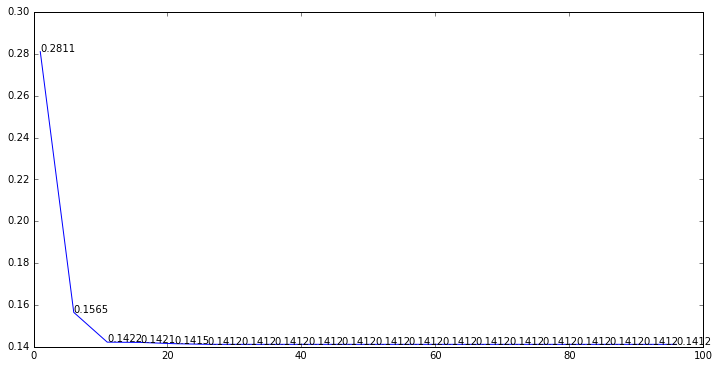

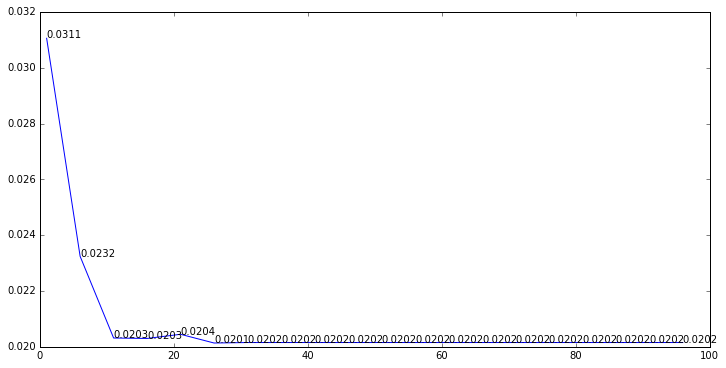

In [30]:
draw_result(gs.grid_scores_,'max_depth')

# So 30 seems the best

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

# Tune the min_samples_split
print "Random forest with mse"
params={
    'n_estimators':[250],
    'max_features':[0.21],
    'max_depth':[30],
    'min_samples_split':[x for x in range(2,15)]
        }
print 'Params to search ',
print params

rfc = RandomForestRegressor(criterion='mse', n_jobs=-1,random_state=42)
gs = GridSearchCV(rfc, params,cv=5,scoring=rmse_loss,verbose=3)
gs.fit(X_train, y_train)
print 'Report scores'
print gs.grid_scores_
print("Report best params for random forest")
best_parameters, score, _ = max(gs.grid_scores_, key=lambda x: x[1])
reportParams(best_parameters, score)


# get the best regressor
rfc_best=gs.best_estimator_
print 'Params for best estimator are ',rfc_best.get_params()
rfc_best.fit(X_train,y_train)
print 'Now predict'
rfc_predict=rfc_best.predict(X_train)
print 'Predicted values are ',rfc_predict
print('RFC MSE {score}'.format(score=rmse_log_error(y_train, rfc_predict)))

# Calculate stats
predict_series=pd.Series(rfc_predict)
print "Std: ",np.std(predict_series)," Mean: ",np.mean(predict_series)
print 'Min: ',min(predict_series),' Max: ',max(predict_series)

Random forest with mse
Params to search  {'n_estimators': [250], 'max_features': [0.21], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'max_depth': [30]}
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30 
[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, score=-0.131398 -   2.0s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, score=-0.153589 -   1.5s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, score=-0.172705 -   1.5s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30 
[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, score=-0.133957 -   1.4s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30 
[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, score=-0.114068 -   1.1s
[CV] max_features=0.21, min_samples_split=3, n_estimators=250, max_depth=30 
[CV]  max_features=0.21, min_samples_split=3, n_estimators=250, max_depth=30, score=-0.131974 -   1.2s
[CV] max_features=0.21, min_samples_split=3, n_estimators=250, max_depth=30 
[CV]  max_features=0.21, min_samples_split=3, n_estimators=250, max_depth=30, score=-0.155132 -   1.2s
[CV] max_features=0.21, min_samples_split=3, n_estimators=250, max_depth=30 
[CV]  max_features=0.21, min_samples_split=3, n_estimators=250, max_depth=30, score=-0.176795 -   1.

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  1.5min finished


Report scores
[mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14273, std: 0.02130, params: {'max_features': 0.21, 'min_samples_split': 3, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14215, std: 0.02064, params: {'max_features': 0.21, 'min_samples_split': 4, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14286, std: 0.02153, params: {'max_features': 0.21, 'min_samples_split': 5, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14239, std: 0.02018, params: {'max_features': 0.21, 'min_samples_split': 6, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14251, std: 0.02088, params: {'max_features': 0.21, 'min_samples_split': 7, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14300, std: 0.02075, params: {'max_features': 0.21, 'min_samples_split': 8, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14302, std: 0.02091, params: {'max_features': 0.21, 'min_samples_split': 9, 'n_estimators': 250, 'max_depth'

[mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14273, std: 0.02130, params: {'max_features': 0.21, 'min_samples_split': 3, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14215, std: 0.02064, params: {'max_features': 0.21, 'min_samples_split': 4, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14286, std: 0.02153, params: {'max_features': 0.21, 'min_samples_split': 5, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14239, std: 0.02018, params: {'max_features': 0.21, 'min_samples_split': 6, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14251, std: 0.02088, params: {'max_features': 0.21, 'min_samples_split': 7, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14300, std: 0.02075, params: {'max_features': 0.21, 'min_samples_split': 8, 'n_estimators': 250, 'max_depth': 30}, mean: -0.14302, std: 0.02091, params: {'max_features': 0.21, 'min_samples_split': 9, 'n_estimators': 250, 'max_depth': 30}, mean: -

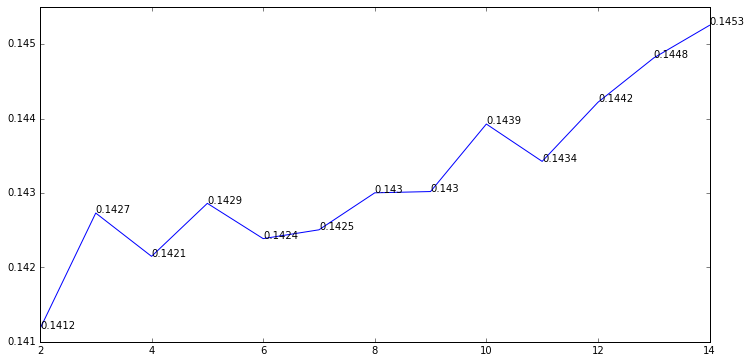

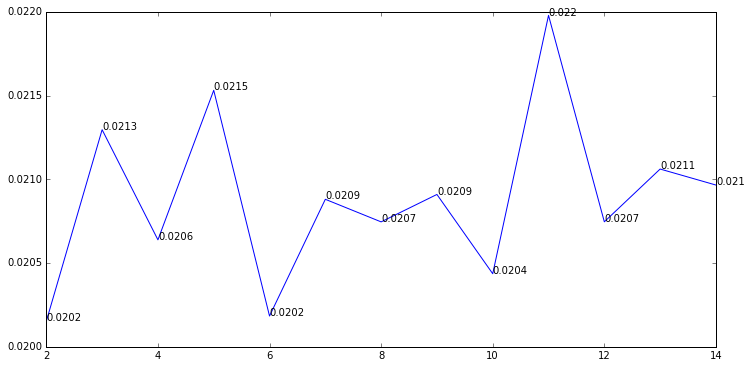

In [32]:
draw_result(gs.grid_scores_,'min_samples_split')

# Stay with 2

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

# Tune the min_samples_leaf
print "Random forest with mse"
params={
    'n_estimators':[250],
    'max_features':[0.21],
    'max_depth':[30],
    'min_samples_split':[2],
    'min_samples_leaf':[x for x in range(1,11,1)]
        }
print 'Params to search ',
print params

rfc = RandomForestRegressor(criterion='mse', n_jobs=-1,random_state=42)
gs = GridSearchCV(rfc, params,cv=5,scoring=rmse_loss,verbose=3)
gs.fit(X_train, y_train)
print 'Report scores'
print gs.grid_scores_
print("Report best params for random forest")
best_parameters, score, _ = max(gs.grid_scores_, key=lambda x: x[1])
reportParams(best_parameters, score)


# get the best regressor
rfc_best=gs.best_estimator_
print 'Params for best estimator are ',rfc_best.get_params()
rfc_best.fit(X_train,y_train)
print 'Now predict'
rfc_predict=rfc_best.predict(X_train)
print 'Predicted values are ',rfc_predict
print('RFC MSE {score}'.format(score=rmse_log_error(y_train, rfc_predict)))

# Calculate stats
predict_series=pd.Series(rfc_predict)
print "Std: ",np.std(predict_series)," Mean: ",np.mean(predict_series)
print 'Min: ',min(predict_series),' Max: ',max(predict_series)

Random forest with mse
Params to search  {'n_estimators': [250], 'max_features': [0.21], 'min_samples_split': [2], 'max_depth': [30], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1 
[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1, score=-0.131398 -   1.2s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1, score=-0.153589 -   1.5s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1, score=-0.172705 -   1.1s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1 
[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1, score=-0.133957 -   1.0s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1 
[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=1, score=-0.114068 -   1.3s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=2 
[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=2, score=-0.131489 -   1.3s
[CV] max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=2 
[CV]  max_features=0.21, min_samples_split=2, n_estimators=250, max_depth=30, min_samples_leaf=2, score=-0.154300 -   1.

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.0min finished


Report scores
[mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 1}, mean: -0.14131, std: 0.02143, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 2}, mean: -0.14396, std: 0.02063, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 3}, mean: -0.14552, std: 0.02071, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 4}, mean: -0.14704, std: 0.02126, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 5}, mean: -0.14892, std: 0.02157, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 6}, mean: -0.15034, std: 0.02172, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 25

[mean: -0.14117, std: 0.02015, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 1}, mean: -0.14131, std: 0.02143, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 2}, mean: -0.14396, std: 0.02063, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 3}, mean: -0.14552, std: 0.02071, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 4}, mean: -0.14704, std: 0.02126, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 5}, mean: -0.14892, std: 0.02157, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth': 30, 'min_samples_leaf': 6}, mean: -0.15034, std: 0.02172, params: {'max_features': 0.21, 'min_samples_split': 2, 'n_estimators': 250, 'max_depth'

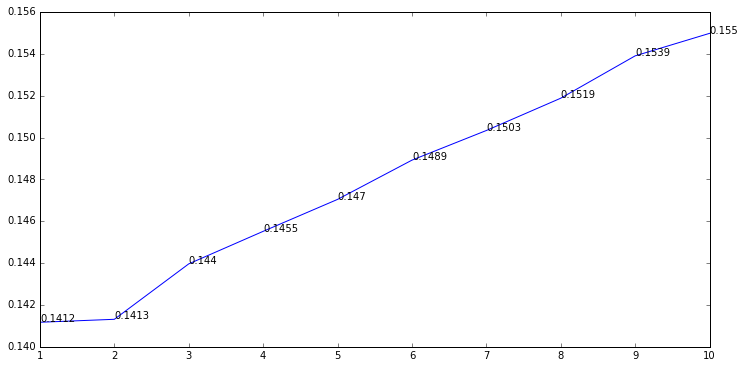

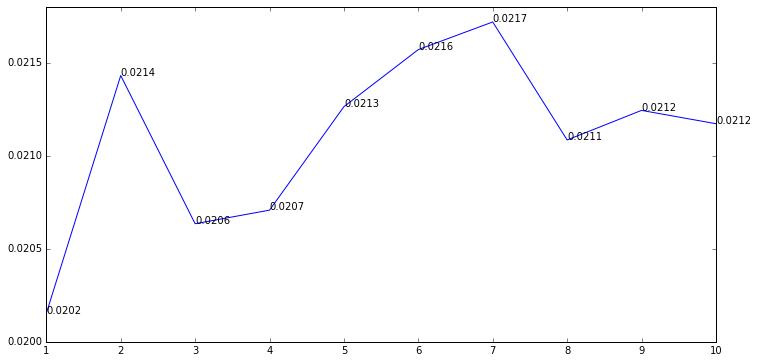

In [34]:
draw_result(gs.grid_scores_,'min_samples_leaf')
# Stay with 1

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

# Tune the max_leaf_nodes
print "Random forest with mse"
params={
    'n_estimators':[250],
    'max_features':[0.21],
    'max_depth':[30],
    'min_samples_split':[2],
    'min_samples_leaf':[1],
    'max_leaf_nodes':[x for x in range(2000,4000,100)]
        }
print 'Params to search ',
print params

rfc = RandomForestRegressor(criterion='mse', n_jobs=-1,random_state=42)
gs = GridSearchCV(rfc, params,cv=5,scoring=rmse_loss,verbose=3)
gs.fit(X_train, y_train)
print 'Report scores'
print gs.grid_scores_
print("Report best params for random forest")
best_parameters, score, _ = max(gs.grid_scores_, key=lambda x: x[1])
reportParams(best_parameters, score)


# get the best regressor
rfc_best=gs.best_estimator_
print 'Params for best estimator are ',rfc_best.get_params()
rfc_best.fit(X_train,y_train)
print 'Now predict'
rfc_predict=rfc_best.predict(X_train)
print 'Predicted values are ',rfc_predict
print('RFC MSE {score}'.format(score=rmse_log_error(y_train, rfc_predict)))

# Calculate stats
predict_series=pd.Series(rfc_predict)
print "Std: ",np.std(predict_series)," Mean: ",np.mean(predict_series)
print 'Min: ',min(predict_series),' Max: ',max(predict_series)

Random forest with mse
Params to search  {'max_leaf_nodes': [2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900], 'min_samples_leaf': [1], 'n_estimators': [250], 'min_samples_split': [2], 'max_features': [0.21], 'max_depth': [30]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30 
[CV]  max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30, score=-0.130712 -   1.1s
[CV] max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30, score=-0.152452 -   1.2s
[CV] max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV]  max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30, score=-0.174185 -   1.2s
[CV] max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30 
[CV]  max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30, score=-0.133084 -   1.3s
[CV] max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30 
[CV]  max_leaf_nodes=2000, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30, score=-0.112048 -   1.3s
[CV] max_leaf_nodes=2100, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30 
[CV]  max_leaf_nodes=2100, min_samples_leaf=1, n_estimators=250, min_samples_split=2, max_features=0.21, max_depth=30, score=-0.130712 -   1.3s
[CV] max_leaf_nodes=2100, min_samples_leaf=1, n_estimators=250, min_sa

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


Report scores
[mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2000, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2100, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2200, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2300, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2400, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2500, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2,

[mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2000, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2100, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2200, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2300, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2400, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 0.21, 'max_depth': 30}, mean: -0.14053, std: 0.02116, params: {'max_leaf_nodes': 2500, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features

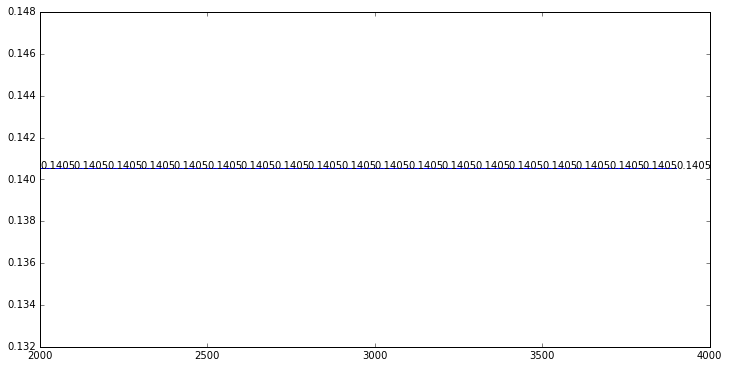

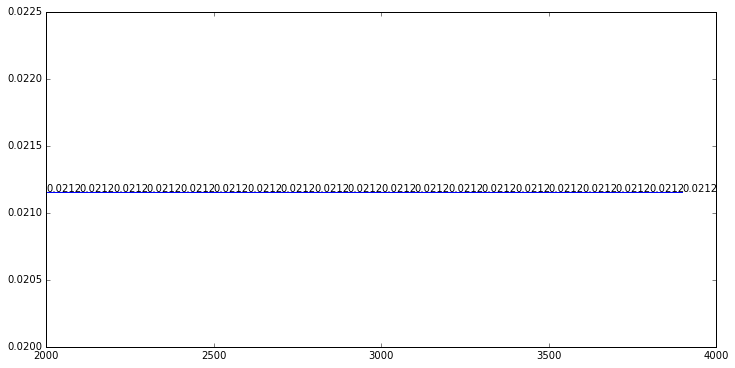

In [36]:
draw_result(gs.grid_scores_,'max_leaf_nodes')
# This is f**king irrelevant man!